In [44]:
# loading libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import itertools

In [45]:
# loading data
games = pd.read_csv("data_raw/game.csv")
team_info = pd.read_csv("data_raw/team_info.csv")

## Data quality check / cleaning / preparation 

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.** An example is given below.

### Data quality check
*By Tess Wagner*

The code below visualizes the distribution of all the variables in the dataset, and their association with the response.

For this project, our response variable is whether a team made the playoffs or not. In the original dataset, the response variable was not clearly visable. Therefore, we cannot show the associations between the possible predictor variables and reponse variables until after the data has been cleaned. (Included below the cleaning section)

In [46]:
print("This dataset has data for", games.shape[0], "NHL games spanning from the", games.loc[games.season.argmin(), 'season'], 'season to the', games.loc[games.season.argmax(), 'season'], 'season.')

This dataset has data for 26305 NHL games spanning from the 20002001 season to the 20192020 season.


<AxesSubplot:xlabel='date_time_GMT', ylabel='Count'>

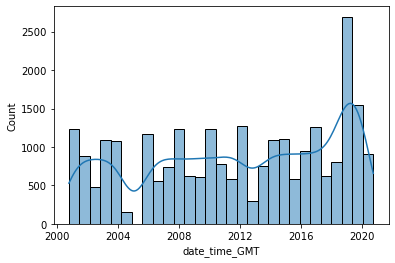

In [47]:
# distribution of the continuous variable
games_continuous = pd.to_datetime(games.iloc[:, 3])
sns.histplot(games_continuous, kde=True)

In [48]:
games_categorical = games.iloc[:, itertools.chain(range(0, 3), range(4, 15))]
games_continuous = games.iloc[:, 3]

In [49]:
# distribution of categorical variables
dist_table_cat = pd.DataFrame()
dist_table_cat['unique_counts'] = games_categorical.apply(lambda x: len(x.unique()))
dist_table_cat['missing_values'] = games_categorical.isna().sum()
dist_table_cat

,unique_counts,missing_values
game_id,23735,0
season,19,0
type,3,0
away_team_id,36,0
home_team_id,36,0
away_goals,12,0
home_goals,12,0
outcome,8,0
home_rink_side_start,3,1196
venue,116,0


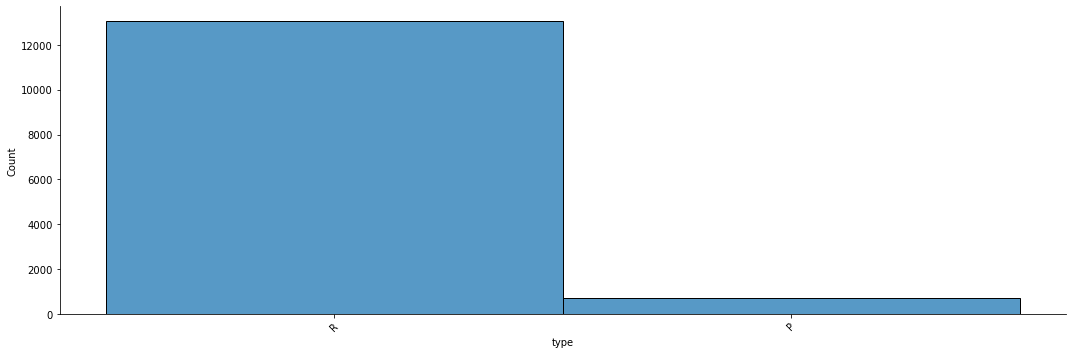

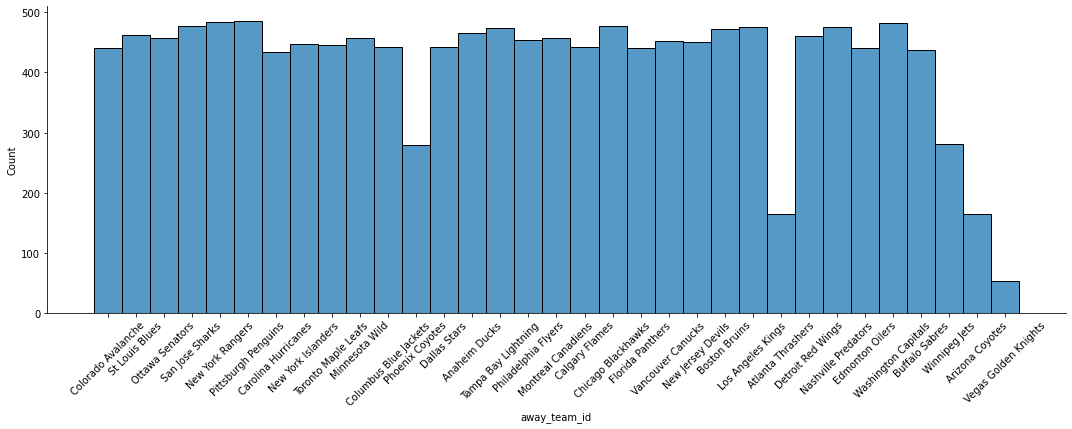

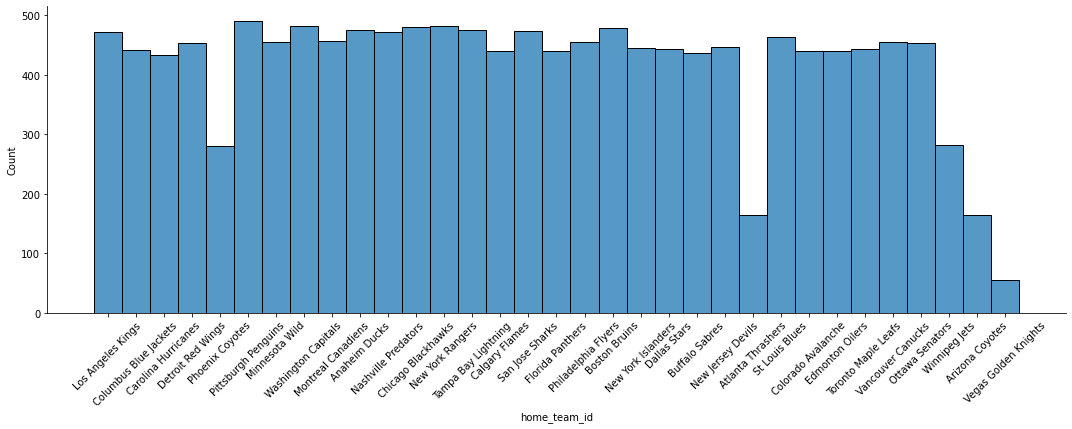

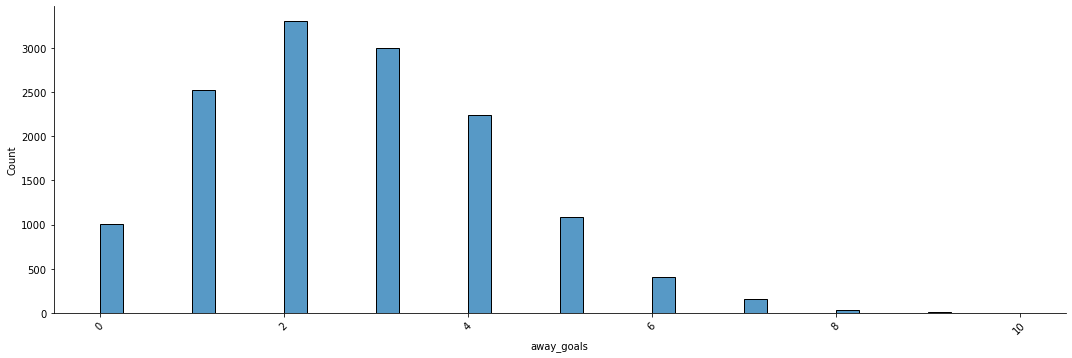

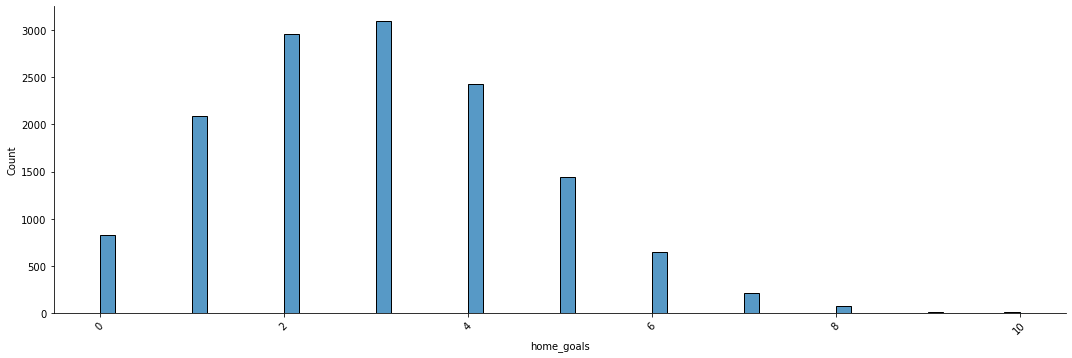

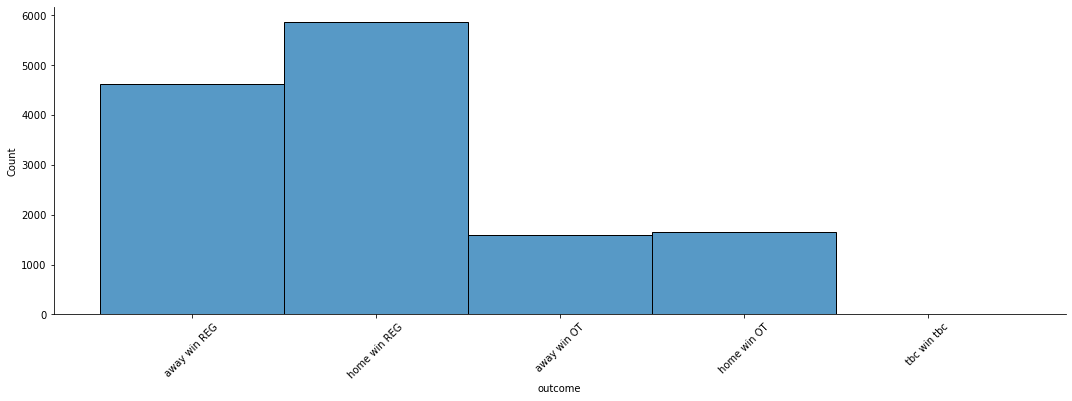

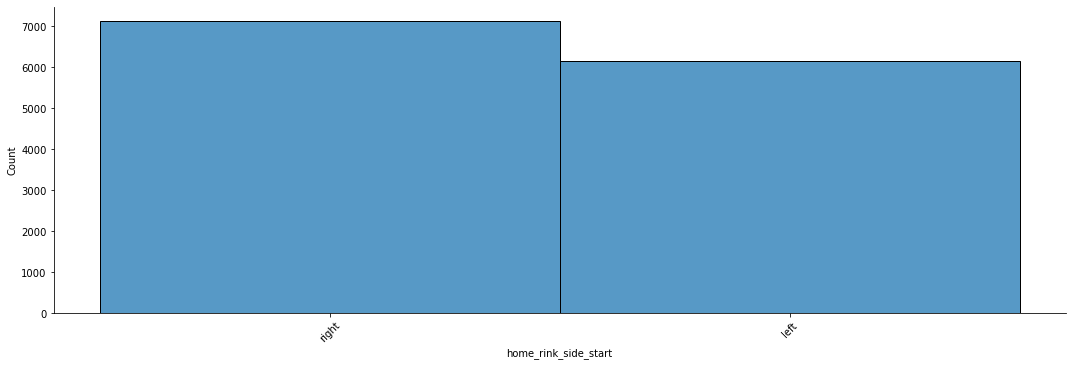

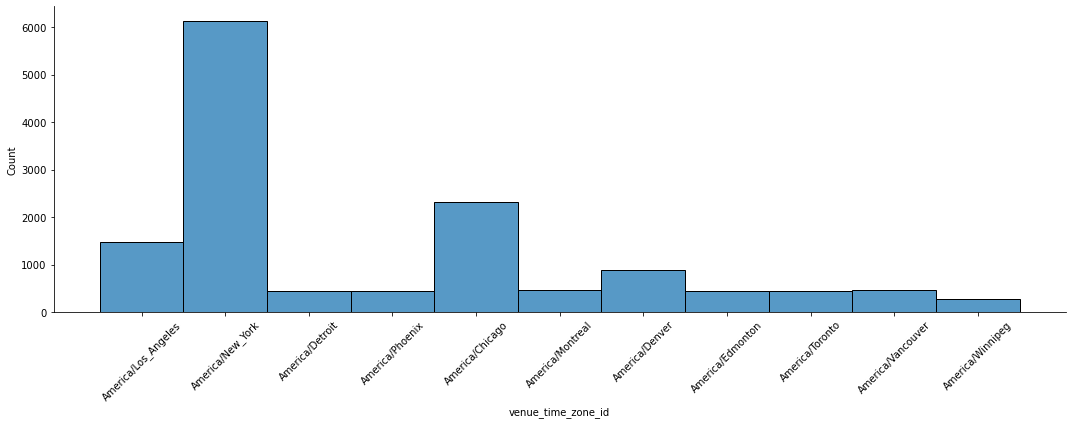

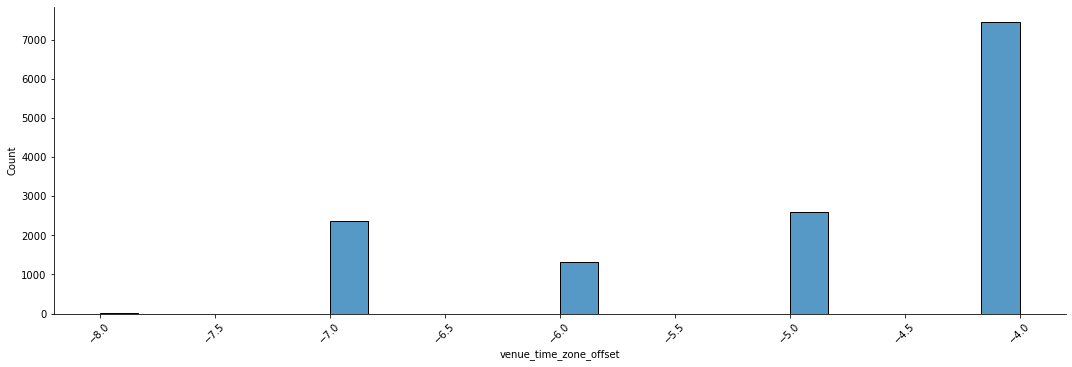

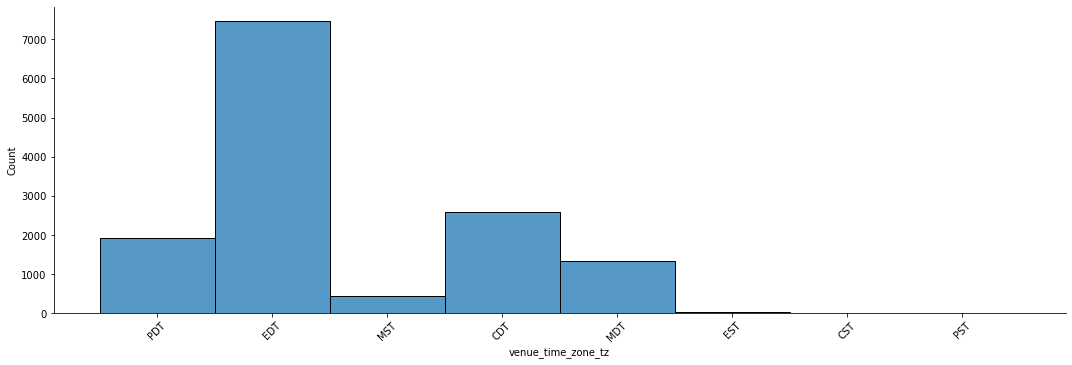

In [133]:
# frequency of categorical variables
cols_to_show_freq = ['type', 'away_team_id', 'home_team_id', 'away_goals', 'home_goals', 'outcome', 'home_rink_side_start', 'venue_time_zone_id', 'venue_time_zone_offset', 'venue_time_zone_tz']
for column in cols_to_show_freq:
    z = sns.displot(data = games, x = column, kind = 'hist', aspect = 3)
    plt.xticks(rotation=45)

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85],
 [Text(0, 0, 'Staples Center'),
  Text(1, 0, 'Nationwide Arena'),
  Text(2, 0, 'RBC Center'),
  Text(3, 0, 'Joe Louis Arena'),
  Text(4, 0, 'Jobing.com Arena'),
  Text(5, 0, 'Mellon Arena'),
  Text(6, 0, 'Xcel Energy Center'),
  Text(7, 0, 'Verizon Center'),
  Text(8, 0, 'Centre Bell'),
  Text(9, 0, 'Honda Center'),
  Text(10, 0, 'Sommet Center'),
  Text(11, 0, 'United Center'),
  Text(12, 0, 'Madison Square Garden'),
  Text(13, 0, 'St. Pete Times Forum'),
  Text(14, 0, 'Pengrowth Saddled

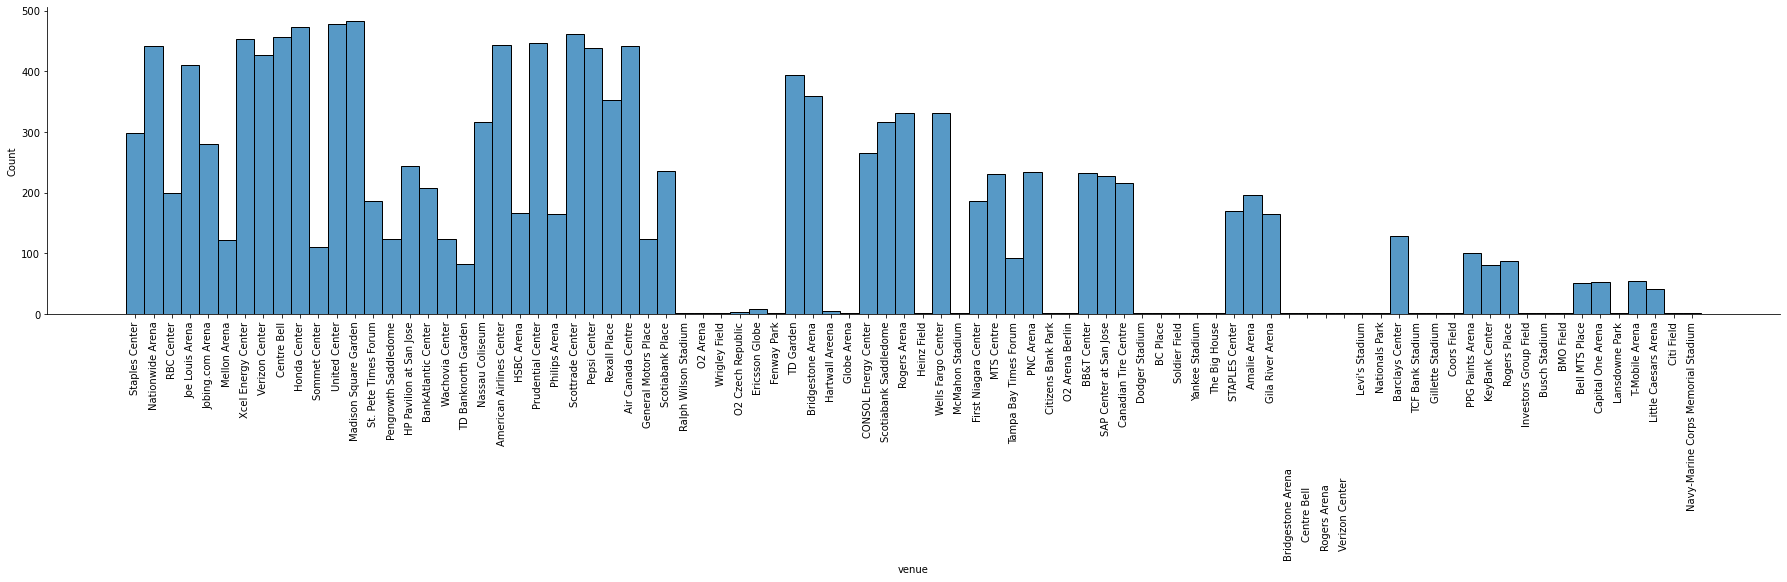

In [137]:
# frequency of venue
z = sns.displot(data = games, x = 'venue', kind = 'hist', aspect = 5)
plt.xticks(rotation=90)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 [Text(0, 0, '20072008'),
  Text(1, 0, '20082009'),
  Text(2, 0, '20092010'),
  Text(3, 0, '20102011'),
  Text(4, 0, '20112012'),
  Text(5, 0, '20122013'),
  Text(6, 0, '20132014'),
  Text(7, 0, '20142015'),
  Text(8, 0, '20152016'),
  Text(9, 0, '20162017'),
  Text(10, 0, '20172018')])

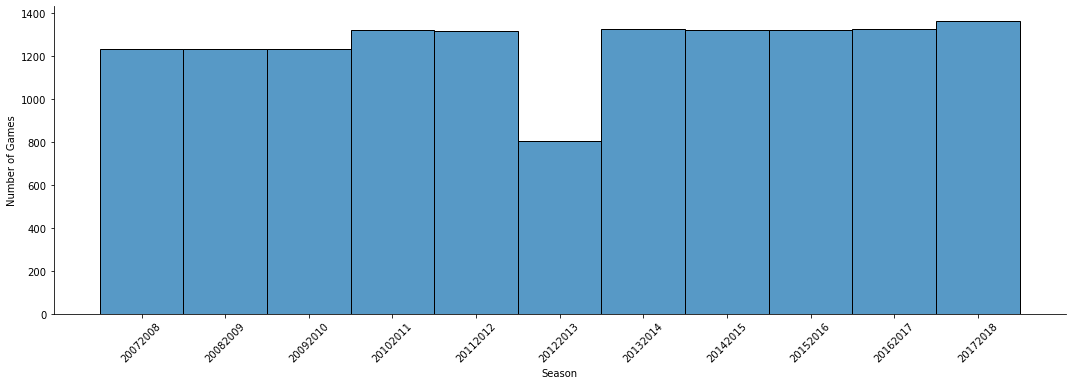

In [129]:
# frequency of seasons
x = games.season.apply(lambda x:str(x))

z = sns.displot(data = games, x = x, kind = 'hist', aspect = 3)
z.set_axis_labels("Season", "Number of Games")
plt.xticks(rotation=45)

We want to use game data from seasons where there is data for the full 82 games played by each team. After checking the 20122013 data, we found that a large chunk of game data was missing. For the 20182019 and 20192020 seasons, many of the games were duplicated.

### Data cleaning
*By Tess Wagner*

From the data quality check we realized that:

1. We needed to keep data only from the games of the ten seasons we wanted to use to build our model. We are keeping data from the 2007-08 season through the 2017-18 season. (We are not keeping data from 
2. We can drop the columns in `game.csv` and `team_info.csv` that we know we will not use (`venue_link`, `franchiseId`, `abbreviation`, `link`).
3. To get a full team name, we combined the variables `teamName` and `shortName` (and fixed the NY team names).
4. To make it easier to identify which team played which games, we replaced `team_id` (a numerical value) in the game dataset with `team_name` from the team info dataset.
5. We separated the games dataset into regular season games so that we do not factor playoff game data into our model. 
6. We dropped `team_id` from the team names dataset as it is no longer useful.
7. Next, we wanted to get datasets for each season with each team's stats. We began by creating new columns with away and home wins and away and home losses. 
8. Then we separated the regular season game data into separate dataframes - one for each season. We also created the same amount of dataframes with just team names so that we can later fill in the season statistics data into these mostly empty dataframes.
9. After that, we created some functions to fill in the team season statistics dataframes with predictors that we might be interested in.
10. Then we got lists of all of the teams that made the playoffs in each season and added the column `made_playoffs` to designate whether a team made playoffs that season.


The code below implements the above cleaning.

In [52]:
# importing the datasets
games = pd.read_csv("data_raw/game.csv")
team_info = pd.read_csv("data_raw/team_info.csv")

In [53]:
# filtering data from the 20072008 through the 20172018 seasons
games = games[(games['season'] >= 20072008) & (games['season'] <= 20172018)].sort_values('season')

In [54]:
# dropping columns that we know we wont use in our model
games.drop('venue_link', axis = 1, inplace = True)
team_info.drop(['franchiseId', 'abbreviation', 'link'], axis = 1, inplace = True)

In [55]:
# combining team city and team nickname to create full team name
team_info['team_name'] = team_info['shortName'] + ' ' + team_info['teamName']
team_info.replace(['NY Rangers Rangers', 'NY Islanders Islanders'], ['New York Rangers', 'New York Islanders'], inplace = True)
team_info.drop(['shortName', 'teamName'], axis = 1, inplace = True)

In [56]:
# replacing team id numbers with full team names
list_of_ids = team_info['team_id'].values

for Id in list_of_ids:
    games.away_team_id.replace(Id, team_info[team_info['team_id'] == Id]['team_name'].values[0], inplace = True)
    games.home_team_id.replace(Id, team_info[team_info['team_id'] == Id]['team_name'].values[0], inplace = True)

In [57]:
# getting dataframe with only regular season games
regular_season_games = games[games['type'] == 'R']

In [58]:
# getting rid of team id in team names dataset
team_names = team_info.drop('team_id', axis = 1)

In [59]:
# adding columns to organize game outcomes 
regular_season_games['away_wins'] = regular_season_games.loc[regular_season_games.outcome.isin(['away win OT', 'away win REG']), 'away_team_id']
regular_season_games['home_wins'] = regular_season_games.loc[regular_season_games.outcome.isin(['home win OT', 'home win REG']), 'home_team_id']
regular_season_games['away_losses'] = regular_season_games.loc[regular_season_games.outcome.isin(['home win OT', 'home win REG']), 'away_team_id']
regular_season_games['home_losses'] = regular_season_games.loc[regular_season_games.outcome.isin(['away win OT', 'away win REG']), 'home_team_id']

C:\Users\csky2\AppData\Local\Temp\ipykernel_85248\96904905.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  regular_season_games['away_wins'] = regular_season_games.loc[regular_season_games.outcome.isin(['away win OT', 'away win REG']), 'away_team_id']
C:\Users\csky2\AppData\Local\Temp\ipykernel_85248\96904905.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  regular_season_games['home_wins'] = regular_season_games.loc[regular_season_games.outcome.isin(['home win OT', 'home win REG']), 'home_team_id']


In [60]:
# separating the data by season
games_07_08 = regular_season_games[regular_season_games['season'] == 20072008]
games_08_09 = regular_season_games[regular_season_games['season'] == 20082009]
games_09_10 = regular_season_games[regular_season_games['season'] == 20092010]
games_10_11 = regular_season_games[regular_season_games['season'] == 20102011]
games_11_12 = regular_season_games[regular_season_games['season'] == 20112012]
games_13_14 = regular_season_games[regular_season_games['season'] == 20132014]
games_14_15 = regular_season_games[regular_season_games['season'] == 20142015]
games_15_16 = regular_season_games[regular_season_games['season'] == 20152016]
games_16_17 = regular_season_games[regular_season_games['season'] == 20162017]
games_17_18 = regular_season_games[regular_season_games['season'] == 20172018]

In [61]:
# creating dataframes with only team names for each season
teams_07_08 = team_names.copy()
teams_08_09 = team_names.copy()
teams_09_10 = team_names.copy()
teams_10_11 = team_names.copy()
teams_11_12 = team_names.copy()
teams_13_14 = team_names.copy()
teams_14_15 = team_names.copy()
teams_15_16 = team_names.copy()
teams_16_17 = team_names.copy()
teams_17_18 = team_names.copy()

In [62]:
# defining functions
list_of_conditions = ['away_wins', 'home_wins', 'away_losses', 'home_losses']
list_of_teams = team_names.team_name.values

# function to add number of away/home wins/losses to dataframes with team info by season
def get_counts(games_df, team_df):
    for condition in list_of_conditions:
        for team in list_of_teams: 
            team_df.loc[team_df.team_name.isin([team]), condition] = len(games_df[games_df[condition] == team])

# helper function to get number of goals scored per team per season
def _total_goals_scored(team, games_df):
    return games_df.loc[games_df.away_team_id.isin([team]), 'away_goals'].sum() + games_df.loc[games_df.home_team_id.isin([team]), 'home_goals'].sum()

# helper function to get number of goals against each team per season
def _total_goals_against(team, games_df):
    return games_df.loc[games_df.away_team_id.isin([team]), 'home_goals'].sum() + games_df.loc[games_df.home_team_id.isin([team]), 'away_goals'].sum()

# function to add number of goals scored and goals against to dataframes with team info by season
def get_goal_counts(games_df, team_df):
    for team in list_of_teams:
        team_df.loc[team_df.team_name.isin([team]), 'total_goals_scored'] = _total_goals_scored(team, games_df)
        team_df.loc[team_df.team_name.isin([team]), 'total_goals_against'] = _total_goals_against(team, games_df)
        
# function to calculate/add the goal differential for each team per season
def get_goal_diff(games_df, team_df):
    for team in list_of_teams:
        team_df.loc[team_df.team_name.isin([team]), 'goal_diff'] = (team_df.loc[team_df.team_name.isin([team]), 'total_goals_scored']) - (team_df.loc[team_df.team_name.isin([team]), 'total_goals_against'])
        
# function to add a column specifying whether a team made the playoffs
def make_playoff_team(list_of_teams, team_df):
    team_df.made_playoffs.fillna(value = 'No', inplace = True)
    for team in list_of_teams: 
        team_df.loc[team_df.team_name.isin([team]), 'made_playoffs'] = 'Yes'

In [63]:
# executing the functions
get_counts(games_07_08, teams_07_08)
get_counts(games_08_09, teams_08_09)
get_counts(games_09_10, teams_09_10)
get_counts(games_10_11, teams_10_11)
get_counts(games_11_12, teams_11_12)
get_counts(games_13_14, teams_13_14)
get_counts(games_14_15, teams_14_15)
get_counts(games_15_16, teams_15_16)
get_counts(games_16_17, teams_16_17)
get_counts(games_17_18, teams_17_18)

get_goal_counts(games_07_08, teams_07_08)
get_goal_counts(games_08_09, teams_08_09)
get_goal_counts(games_09_10, teams_09_10)
get_goal_counts(games_10_11, teams_10_11)
get_goal_counts(games_11_12, teams_11_12)
get_goal_counts(games_13_14, teams_13_14)
get_goal_counts(games_14_15, teams_14_15)
get_goal_counts(games_15_16, teams_15_16)
get_goal_counts(games_16_17, teams_16_17)
get_goal_counts(games_17_18, teams_17_18)

get_goal_diff(games_07_08, teams_07_08)
get_goal_diff(games_08_09, teams_08_09)
get_goal_diff(games_09_10, teams_09_10)
get_goal_diff(games_10_11, teams_10_11)
get_goal_diff(games_11_12, teams_11_12)
get_goal_diff(games_13_14, teams_13_14)
get_goal_diff(games_14_15, teams_14_15)
get_goal_diff(games_15_16, teams_15_16)
get_goal_diff(games_16_17, teams_16_17)
get_goal_diff(games_17_18, teams_17_18)

In [64]:
teams_07_08['made_playoffs'] = np.nan
teams_08_09['made_playoffs'] = np.nan
teams_09_10['made_playoffs'] = np.nan
teams_10_11['made_playoffs'] = np.nan
teams_11_12['made_playoffs'] = np.nan
teams_13_14['made_playoffs'] = np.nan
teams_14_15['made_playoffs'] = np.nan
teams_15_16['made_playoffs'] = np.nan
teams_16_17['made_playoffs'] = np.nan
teams_17_18['made_playoffs'] = np.nan

In [65]:
playoffs_07_08 = ['Anaheim Ducks','Boston Bruins','Calgary Flames','Colorado Avalanche','Dallas Stars','Detroit Red Wings','Minnesota Wild','Montreal Canadiens','Nashville Predators','New Jersey Devils','New York Rangers','Ottawa Senators','Philadelphia Flyers','Pittsburgh Penguins','San Jose Sharks','Washington Capitals']
playoffs_08_09 = ['Pittsburgh Penguins','Detroit Red Wings','Chicago Blackhawks','Carolina Hurricanes','Boston Bruins','Anaheim Ducks','Washington Capitals','Vancouver Canucks','New Jersey Devils','New York Rangers','Philadelphia Flyers','Calgary Flames','San Jose Sharks','St Louis Blues','Montreal Canadiens','Columbus Blue Jackets']
playoffs_09_10 = ['Chicago Blackhawks','Philadelphia Flyers','Montreal Canadiens','San Jose Sharks','Pittsburgh Penguins','Boston Bruins','Vancouver Canucks','Detroit Red Wings','Phoenix Coyotes','Washington Capitals','Ottawa Senators','Colorado Avalanche','Buffalo Sabres','Los Angeles Kings','Nashville Predators','New Jersey Devils']
playoffs_10_11 = ['San Jose Sharks','Boston Bruins','Vancouver Canucks','Nashville Predators','Washington Capitals','Tampa Bay Lightning','Philadelphia Flyers','Pittsburgh Penguins','Chicago Blackhawks','Buffalo Sabres','Detroit Red Wings','Montreal Canadiens','Anaheim Ducks','Los Angeles Kings','New York Rangers','Phoenix Coyotes']
playoffs_11_12 = ['Los Angeles Kings','New Jersey Devils','New York Rangers','Phoenix Coyotes','Washington Capitals','Nashville Predators','Philadelphia Flyers','St Louis Blues','Boston Bruins','Ottawa Senators','Florida Panthers','Pittsburgh Penguins','Chicago Blackhawks','Detroit Red Wings','Vancouver Canucks','San Jose Sharks']
playoffs_13_14 = ['Los Angeles Kings','New York Rangers','Chicago Blackhawks','Montreal Canadiens','Boston Bruins','Anaheim Ducks','Pittsburgh Penguins','Minnesota Wild','Colorado Avalanche','Philadelphia Flyers','San Jose Sharks','Dallas Stars','Columbus Blue Jackets','St Louis Blues','Detroit Red Wings','Tampa Bay Lightning']
playoffs_14_15 = ['Chicago Blackhawks','Tampa Bay Lightning','Anaheim Ducks','New York Rangers','Washington Capitals','Montreal Canadiens','Calgary Flames','Minnesota Wild','New York Islanders','Detroit Red Wings','Ottawa Senators','Nashville Predators','Vancouver Canucks','St Louis Blues','Pittsburgh Penguins','Winnipeg Jets']
playoffs_15_16 = ['Pittsburgh Penguins','San Jose Sharks','Tampa Bay Lightning','St Louis Blues','Dallas Stars','Nashville Predators','Washington Capitals','New York Islanders','Chicago Blackhawks','Anaheim Ducks','Minnesota Wild','Florida Panthers','Philadelphia Flyers','New York Rangers','Detroit Red Wings','Los Angeles Kings']
playoffs_16_17 = ['Pittsburgh Penguins','Nashville Predators','Ottawa Senators','Anaheim Ducks','Edmonton Oilers','Washington Capitals','St Louis Blues','New York Rangers','San Jose Sharks','Montreal Canadiens','Boston Bruins','Toronto Maple Leafs','Minnesota Wild','Columbus Blue Jackets','Calgary Flames','Chicago Blackhawks']
playoffs_17_18 = ['Washington Capitals','Vegas Golden Knights','Tampa Bay Lightning','Winnipeg Jets','Nashville Predators','San Jose Sharks','Pittsburgh Penguins','Boston Bruins','Toronto Maple Leafs','Philadelphia Flyers','Colorado Avalanche','Columbus Blue Jackets','Minnesota Wild','New Jersey Devils','Los Angeles Kings','Anaheim Ducks']

In [66]:
make_playoff_team(playoffs_07_08, teams_07_08)
make_playoff_team(playoffs_08_09, teams_08_09)
make_playoff_team(playoffs_09_10, teams_09_10)
make_playoff_team(playoffs_10_11, teams_10_11)
make_playoff_team(playoffs_11_12, teams_11_12)
make_playoff_team(playoffs_13_14, teams_13_14)
make_playoff_team(playoffs_14_15, teams_14_15)
make_playoff_team(playoffs_15_16, teams_15_16)
make_playoff_team(playoffs_16_17, teams_16_17)
make_playoff_team(playoffs_17_18, teams_17_18)

In [67]:
szn_lists = [teams_07_08, teams_08_09, teams_09_10, teams_10_11, teams_11_12, teams_13_14, teams_14_15\
             , teams_15_16, teams_16_17, teams_17_18]

full_szns = pd.concat(szn_lists, axis=0, ignore_index=True)

###### Association of Variables with the Response

<AxesSubplot:xlabel='made_playoffs', ylabel='goal_diff'>

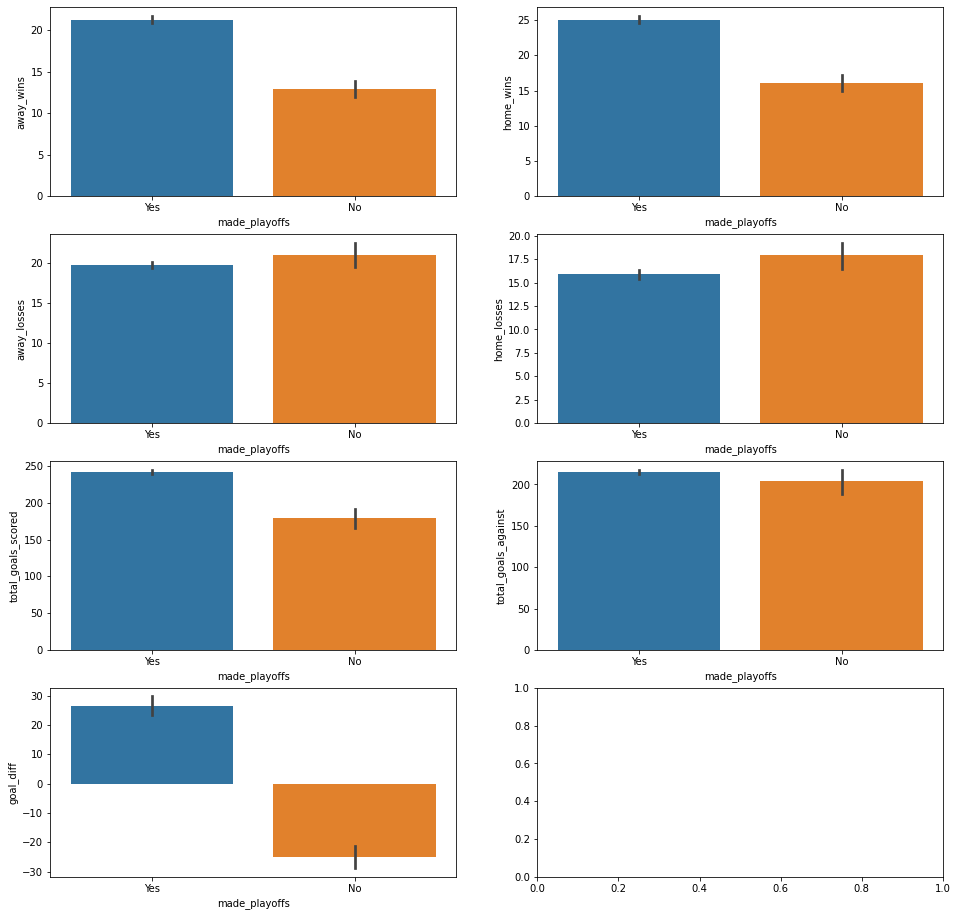

In [68]:
# using barplots to show the associations of the predictors with the response
fig, axes = plt.subplots(nrows = 4, ncols = 2, figsize = (16,16))
plt.subplots_adjust(wspace = 0.2, hspace = 0.2)

sns.barplot(ax = axes[0,0], y = full_szns.away_wins, x = full_szns.made_playoffs)
sns.barplot(ax = axes[0,1], y = full_szns.home_wins, x = full_szns.made_playoffs)
sns.barplot(ax = axes[1,0], y = full_szns.away_losses, x = full_szns.made_playoffs)
sns.barplot(ax = axes[1,1], y = full_szns.home_losses, x = full_szns.made_playoffs)
sns.barplot(ax = axes[2,0], y = full_szns.total_goals_scored, x = full_szns.made_playoffs)
sns.barplot(ax = axes[2,1], y = full_szns.total_goals_against, x = full_szns.made_playoffs)
sns.barplot(ax = axes[3,0], y = full_szns.goal_diff, x = full_szns.made_playoffs)

## Data preparation
*z*

The following data preparation steps helped us to prepare our data for implementing various modeling / validation techniques:

1. Since we need to predict house price, we derived some new predictors *(from existing predictors)* that intuitively seem to be helpuful to predict house price. 

2. We have shuffled the dataset to prepare it for K-fold cross validation.

3. We have created a standardized version of the dataset, as we will use it to develop Lasso / Ridge regression models.

In [25]:
######---------------Creating new predictors----------------#########

# move goal differential stuff here??

### EDA data preparation
*Samuel Sword*

To make the historic data better suited for EDA, I imported it and combined them the way that other members had done, but also added some extra columns with valuable statistics, and made two more data sets based off the full seasons dataset: one for playoff teams, and one for non-playoff teams. This was done so that I could analyze possible benchmarks and trends in playoff teams:

In [69]:
# # this code is borrowed from another team member's data cleaning/wrangling
# szn_lists = [teams_07_08, teams_08_09, teams_09_10, teams_10_11, teams_11_12, teams_13_14, teams_14_15\
#              , teams_15_16, teams_16_17, teams_17_18]

# full_szns = pd.concat(szn_lists, axis=0, ignore_index=True)

In [70]:
#dropping null rows
full_szns.loc[full_szns['away_wins'] ==0].index.to_list()
full_szns = full_szns.drop(full_szns.loc[full_szns['away_wins'] ==0].index.to_list())

In [71]:
#creating datasets consisting of playoff teams and non playoff teams
PO_teams = full_szns.loc[full_szns['made_playoffs']=="Yes"]
noPO_teams = full_szns.loc[full_szns['made_playoffs']=="No"]

In [72]:
full_szns

,team_name,away_wins,home_wins,away_losses,home_losses,total_goals_scored,total_goals_against,goal_diff,made_playoffs
0,New Jersey Devils,21.0,25.0,20.0,16.0,206.0,197.0,9.0,Yes
1,Philadelphia Flyers,21.0,21.0,20.0,20.0,248.0,233.0,15.0,Yes
2,Los Angeles Kings,15.0,17.0,26.0,24.0,231.0,266.0,-35.0,No
3,Tampa Bay Lightning,11.0,20.0,30.0,21.0,223.0,267.0,-44.0,No
4,Boston Bruins,20.0,21.0,21.0,20.0,212.0,222.0,-10.0,Yes
...,...,...,...,...,...,...,...,...,...
324,Winnipeg Jets,20.0,32.0,21.0,9.0,277.0,218.0,59.0,Yes
325,Edmonton Oilers,17.0,19.0,24.0,22.0,234.0,263.0,-29.0,No
326,Vegas Golden Knights,22.0,29.0,19.0,12.0,272.0,228.0,44.0,Yes
327,Carolina Hurricanes,17.0,19.0,24.0,22.0,228.0,256.0,-28.0,No


In [73]:
#adding useful statistics:

#total wins
PO_teams['total_wins'] = PO_teams.away_wins+PO_teams.home_wins
noPO_teams['total_wins'] = noPO_teams.away_wins+noPO_teams.home_wins
full_szns['total_wins'] = full_szns.away_wins + full_szns.home_wins

#goal differential
PO_teams['goal_diff'] = PO_teams.total_goals_scored-PO_teams.total_goals_against
noPO_teams['goal_diff'] = noPO_teams.total_goals_scored-noPO_teams.total_goals_against
full_szns['goal_diff'] = full_szns.total_goals_scored-full_szns.total_goals_against

C:\Users\csky2\AppData\Local\Temp\ipykernel_85248\922726757.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PO_teams['total_wins'] = PO_teams.away_wins+PO_teams.home_wins
C:\Users\csky2\AppData\Local\Temp\ipykernel_85248\922726757.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  noPO_teams['total_wins'] = noPO_teams.away_wins+noPO_teams.home_wins
C:\Users\csky2\AppData\Local\Temp\ipykernel_85248\922726757.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

The three datasets above were then exported to csv files for any future use in other files. This won't be done here since the files already exist, but those files can be found as "full_seasons.csv", "Playoff_Teams.csv", and "Non_Playoff_Teams.csv" in the repository.

## Exploratory data analysis

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.**

In [74]:
# szn_78 = pd.read_csv('teams_07_08.csv')
# szn_89 = pd.read_csv('teams_08_09.csv')
# szn_910 = pd.read_csv('teams_09_10.csv')
# szn_1011 = pd.read_csv('teams_10_11.csv')
# szn_1112 = pd.read_csv('teams_11_12.csv')
# szn_1314 = pd.read_csv('teams_13_14.csv')
# szn_1415 = pd.read_csv('teams_14_15.csv')
# szn_1516 = pd.read_csv('teams_15_16.csv')
# szn_1617 = pd.read_csv('teams_16_17.csv')
# szn_1718 = pd.read_csv('teams_17_18.csv')

# szn_lists = [szn_78, szn_89, szn_910, szn_1011, szn_1112, szn_1314, szn_1415, szn_1516, szn_1617, szn_1718]
# full_szns = pd.concat(szn_lists, axis=0, ignore_index=True)
PO_teams = full_szns.loc[full_szns['made_playoffs']=="Yes"]
PO_teams['total_wins'] = PO_teams['home_wins'] + PO_teams['away_wins']
PO_teams.describe()

C:\Users\csky2\AppData\Local\Temp\ipykernel_85248\2141586708.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PO_teams['total_wins'] = PO_teams['home_wins'] + PO_teams['away_wins']


,away_wins,home_wins,away_losses,home_losses,total_goals_scored,total_goals_against,goal_diff,total_wins
count,160.000000,160.00000,160.000000,160.00000,160.000000,160.000000,160.000000,160.000000
mean,21.231250,25.08125,19.768750,15.91875,241.468750,215.018750,26.450000,46.312500
std,2.724734,3.00936,2.724734,3.00936,20.624502,17.207016,21.177536,3.908043
min,15.000000,18.00000,13.000000,9.00000,194.000000,165.000000,-24.000000,38.000000
25%,19.000000,23.00000,18.000000,14.00000,226.000000,202.000000,11.000000,43.000000
50%,21.000000,25.00000,20.000000,16.00000,241.000000,216.000000,23.500000,46.000000
75%,23.000000,27.00000,22.000000,18.00000,254.500000,229.000000,39.000000,49.000000
max,28.000000,32.00000,26.000000,23.00000,318.000000,250.000000,85.000000,56.000000


In [76]:
# import statsmodels.formula.api as smf
# import seaborn as sns
# import matplotlib.pyplot as plt
playoff_dummies = pd.get_dummies(full_szns['made_playoffs'])
playoff_dummies['Yes']
playoff_dummies = pd.get_dummies(full_szns, prefix = ['made_playoffs'], columns = ['made_playoffs'])
model = smf.ols(formula = 'made_playoffs_Yes~away_wins+home_wins+away_losses+home_losses+total_goals_scored+total_goals_against', data = playoff_dummies).fit()
model.summary()   

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      made_playoffs_Yes   R-squared:                       0.637
Model:                            OLS   Adj. R-squared:                  0.632
Method:                 Least Squares   F-statistic:                     130.0
Date:                Wed, 15 Mar 2023   Prob (F-statistic):           6.38e-64
Time:                        11:29:21   Log-Likelihood:                -65.259
No. Observations:                 301   AIC:                             140.5
Df Residuals:                     296   BIC:                             159.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0007      0.000      4.304      0.000       0.000       0.001
away_wins               0.0356      0.005      6.504      0.000       0.025       0.046
home_wins               0.0349      0.005      6.457      0.000       0.024       0.046
away_losses            -0.0086      0.005     -1.596      0.111      -0.019       0.002
home_losses            -0.0079      0.005     -1.470      0.143      -0.018       0.003
total_goals_scored      0.0012      0.002      0.728      0.467      -0.002       0.004
total_goals_against    -0.0037      0.002     -2.294      0.022      -0.007      -0.001
==============================================================================
Omnibus:                       27.995   Durbin-Watson:                   2.171
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               10.225
Skew:                          -0.166   Prob(JB):                      0.00602
Kurtosis:                       2.160   Cond. No.                     2.94e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.74e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

### EDA to discover thresholds that differentiate playoff teams from non-playoff teams
*By Samuel Sword*

In [106]:
# #Importing data
full_szns = pd.read_csv('full_seasons.csv')
PO_teams = pd.read_csv('Playoff_Teams.csv')
noPO_teams.to_csv('Non_Playoff_Teams.csv')

In [107]:
# median goals scored for playoff and non playoff teams
print('Median total wins for a playoff team:', (PO_teams.away_wins+PO_teams.home_wins).median())
print('Median total wins for a non-playoff team:', (noPO_teams.away_wins+noPO_teams.home_wins).median())

Median total wins for a playoff team: 46.0
Median total wins for a non-playoff team: 35.0


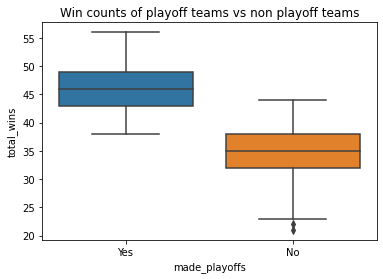

In [108]:
#Boxplot visualizing relationship between playoff/non playoff teams and wins
sns.boxplot(x="made_playoffs", y="total_wins", data=full_szns)
plt.title('Win counts of playoff teams vs non playoff teams', fontsize = 12)
plt.show()

Text(0.5, 1.0, 'Win counts of playoff teams (red) vs non playoff teams (blue)')

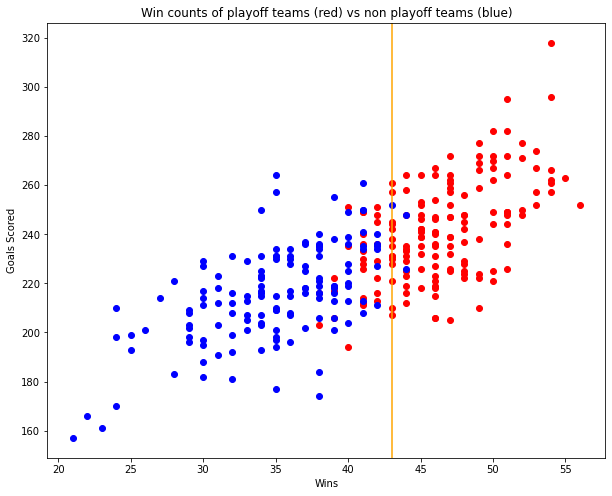

In [109]:
# based on the boxplot, it seems that the median win count of a playoff team might be unncessesarily high. Let's visualize
# a scatter plot of total wins of playoff and non playoff teams:

plt.figure(figsize=(10,8))
plt.scatter(x=PO_teams.total_wins,y = PO_teams.total_goals_scored,c="red")
plt.scatter(x=noPO_teams.total_wins,y = noPO_teams.total_goals_scored,c="blue")
plt.xlabel("Wins")
plt.ylabel("Goals Scored")
plt.axvline(x = 43, c='orange')
plt.title('Win counts of playoff teams (red) vs non playoff teams (blue)')

Above, we can see that at 43 wins (as marked by the orange line), teams seem to be extremely likely to make the playoffs. Only one team that has had 43 wins, hasn't made the playoffs, and only two teams that have had 44 havent. Thus, it seems that using 43 games as a threshold for a playoff caliber team would be a better decision.

In [110]:
# Next, let us explore goal differentials
print('Median goal differential for a playoff team:', (PO_teams.goal_diff).median())
print('Median goal differential for a non-playoff team:', (noPO_teams.goal_diff).median())

Median goal differential for a playoff team: 23.5
Median goal differential for a non-playoff team: -27.0


Text(0.5, 1.0, 'Win counts of playoff teams vs non playoff teams')

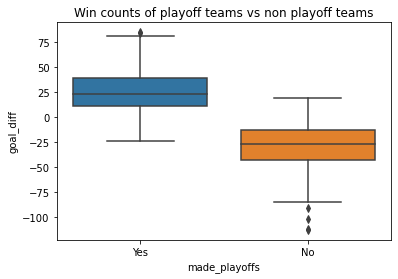

In [111]:
# Visualizing goal differentials between playoff and non-playoff teams:
sns.boxplot(x="made_playoffs", y="goal_diff", data=full_szns)
plt.title('Win counts of playoff teams vs non playoff teams', fontsize = 12)

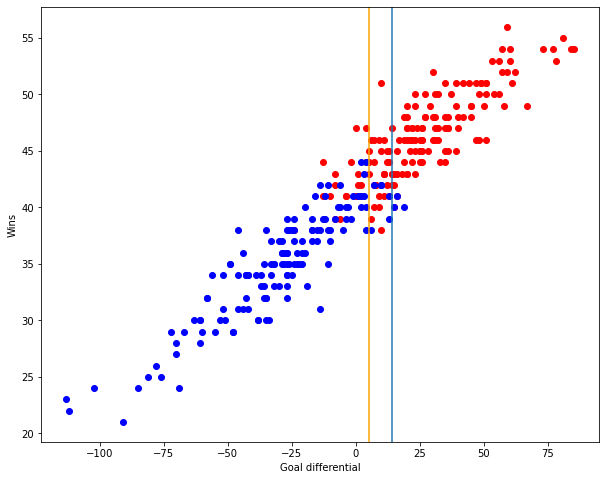

In [112]:
# again, the boxplot reveals that 23.5 as a threshold for goal differential might be unnecessarily high. Below, we can see
# a better threshold to set
plt.figure(figsize=(10,8))
plt.scatter(x=PO_teams.goal_diff,y = PO_teams.total_wins,c="red")
plt.scatter(x=noPO_teams.goal_diff,y = noPO_teams.total_wins,c="blue")
plt.xlabel("Goal differential")
plt.ylabel("Wins")
plt.axvline(x = 14)
plt.axvline(x = 5, c='orange')


If a team has a goal differntial of at least 14 (the blue line), they seem very likely to make it in to the playoffs. If a team has a goal differential greater than 5 (the orange line), they still seem likely to make the playoffs, but slightly less likely than if they have a goal differential of 14. It seems that setting a goal differential of 14 or more as a playoff caliber goal differential is appropriate.

In [113]:
# We can also see that goal differential and total wins seem to have a highly positive, linear relationship. Their
# coefficient is as seen below:
print('Correlation coefficient between goal differential and total wins:', full_szns.corrwith(full_szns.goal_diff).total_wins)

Correlation coefficient between goal differential and total wins: 0.9491691246524291


Goal differential and total wins are very highly correlated, with a correlation coefficient of 0.95! Below, a visualization of the regression between the two variables can be seen.

<AxesSubplot:xlabel='goal_diff', ylabel='total_wins'>

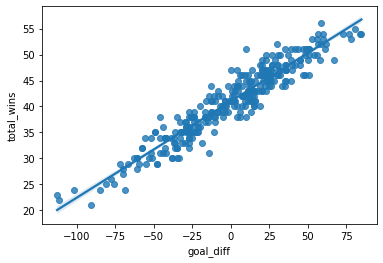

In [114]:
sns.regplot(x=full_szns.goal_diff, y = full_szns.total_wins, data=full_szns)

Furthermore, boxplots of total goals scored and total goals allowed between playoff teams and non-playoff teams were created to better understand how the goal differential breaks down. To explain, there could be a chance that, when breaking down goal differntial into goals scored and goals conceded, playoff teams and non playoff teams are similar in one of the statistics, while playoff teams are much stronger in the other statistic. Based on the boxplots below, playoff teams generally score more than non-playoff teams, as well as concede goals less than non playoff teams.

<AxesSubplot:xlabel='made_playoffs', ylabel='total_goals_scored'>

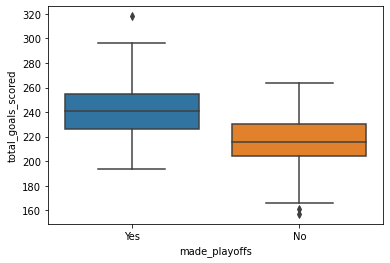

In [115]:
sns.boxplot(x='made_playoffs', y= 'total_goals_scored', data = full_szns)

<AxesSubplot:xlabel='made_playoffs', ylabel='total_goals_against'>

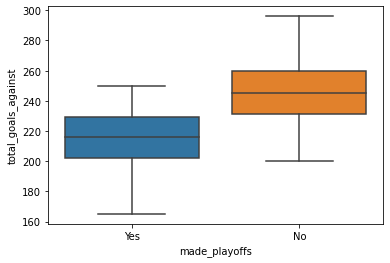

In [116]:
sns.boxplot(x='made_playoffs', y= 'total_goals_against', data = full_szns)

## Developing the model

### Linear Regression:
*By Samuel Sword*

The linear regression model was used to predict how many wins the Predators will end the season with, based on the statistics of historical teams over the past 20 seasons.

In [117]:
#importing the Preds current season stats:
preds_current_stats = pd.read_csv('Nashville Pred. 22-23 Season Stats.csv')

In [118]:
#filtering to our designated cutoff
preds_current_stats = preds_current_stats.head(40)

Below, multiple different models were tested to see what combination of predictors was most accurate. Because we have a fairly low number of predictors, many of which give redundant models when combined, we can use brute force to test the various predictors together and find the best model.

In [119]:
from sklearn.model_selection import train_test_split
#making training and test data from the full seasons dataset to test RSMEs of models
train, test = train_test_split(full_szns, test_size=0.2)

In [126]:
full_szns.columns

Index(['Unnamed: 0', 'team_name', 'away_wins', 'home_wins', 'away_losses',
       'home_losses', 'total_goals_scored', 'total_goals_against',
       'made_playoffs', 'total_wins', 'goal_diff', 'binary_playoffs'],
      dtype='object')

In [121]:
model = smf.ols(formula = 'total_wins~goal_diff', data = train).fit()
prediction = model.predict(test)
np.sqrt(((test.total_wins - prediction)**2).mean())

2.5350290976778864

In [122]:
model = smf.ols(formula = 'total_wins~away_wins+goal_diff', data = train).fit()
prediction = model.predict(test)
np.sqrt(((test.total_wins - prediction)**2).mean())

2.128691750455161

In [123]:
model = smf.ols(formula = 'total_wins~away_losses+goal_diff', data = train).fit()
prediction = model.predict(test)
np.sqrt(((test.total_wins - prediction)**2).mean())

2.1286917504551606

In [124]:
model = smf.ols(formula = 'total_wins~home_wins+goal_diff', data = train).fit()
prediction = model.predict(test)
np.sqrt(((test.total_wins - prediction)**2).mean())

2.2327001519449547

In [125]:
model = smf.ols(formula = 'total_wins~home_losses+goal_diff', data = train).fit()
prediction = model.predict(test)
np.sqrt(((test.total_wins - prediction)**2).mean())

2.2327001519449516

Note that making a model similar to the two above, but with the predictors as home and away losses intead of wins is redundant and yields the same models

In [99]:
model = smf.ols(formula = 'total_wins~home_losses+goal_diff', data = train).fit()
prediction = model.predict(test)
np.sqrt(((test.total_wins - prediction)**2).mean())

1.9702862830868653

In [57]:
#this is the model that fits the data completely (home wins + away wins will give us total wins! Same with home losses +
# + away losses)
model = smf.ols(formula = 'total_wins~home_wins+away_wins+goal_diff', data = train).fit()
prediction = model.predict(test)
np.sqrt(((test.total_wins - prediction)**2).mean())

3.67973832418407e-14

In [58]:
# again, this allows the model to fit the data nearly completely (same would go for away wins + home losses)
model = smf.ols(formula = 'total_wins~home_wins+away_losses+goal_diff', data = train).fit()
prediction = model.predict(test)
np.sqrt(((test.total_wins - prediction)**2).mean())

1.6811064106806714e-13

In [59]:
#testing interactions
model = smf.ols(formula = 'total_wins~away_wins*goal_diff', data = train).fit()
prediction = model.predict(test)
np.sqrt(((test.total_wins - prediction)**2).mean())

1.852133261292527

In [60]:
#testing interactions
model = smf.ols(formula = 'total_wins~home_wins*goal_diff', data = train).fit()
prediction = model.predict(test)
np.sqrt(((test.total_wins - prediction)**2).mean())

2.126423136202005

Based on RSME scores, making a simple multiple linear regression model based on goal differential and away game performance is the most accurate combination of predictors.

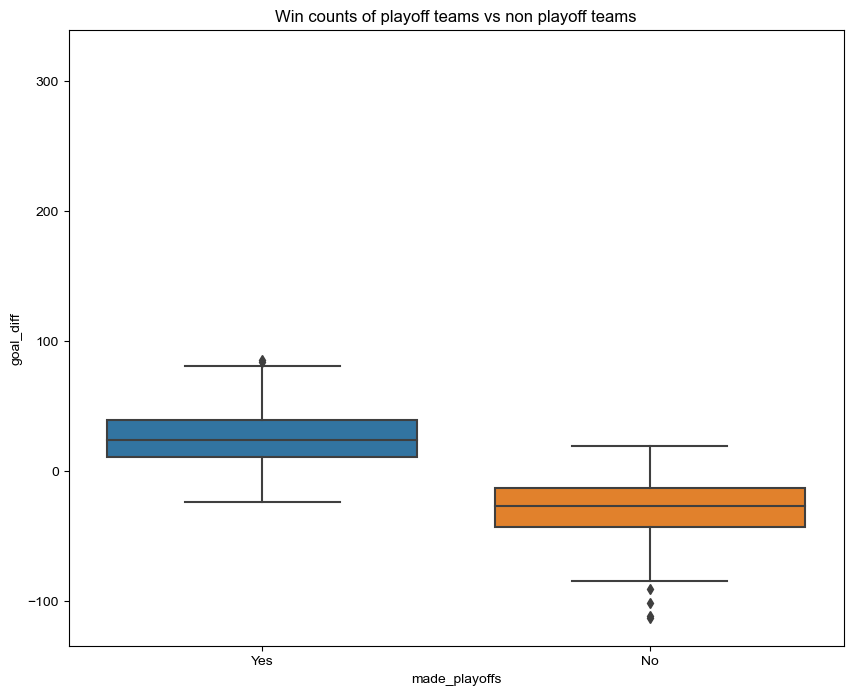

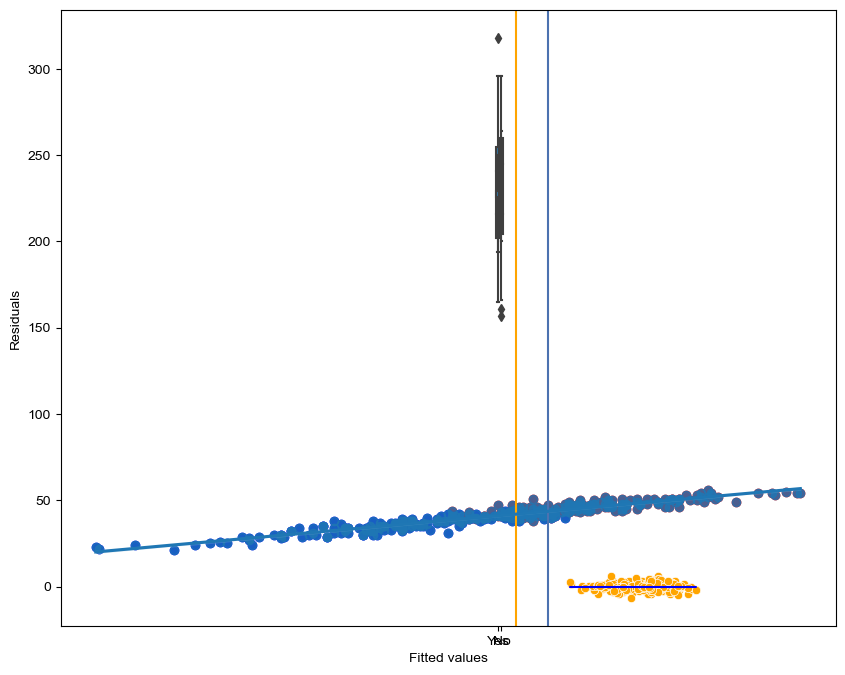

In [61]:
model = smf.ols(formula = 'total_wins~away_wins+goal_diff', data = train).fit()
#Plotting residuals vs fitted values
sns.set(rc={'figure.figsize':(10,6)})
sns.scatterplot(x = (model.fittedvalues), y=(model.resid),color = 'orange')
sns.lineplot(x = [model.fittedvalues.min(),model.fittedvalues.max()],y = [0,0],color = 'blue')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.show()

In [62]:
out = model.outlier_test()

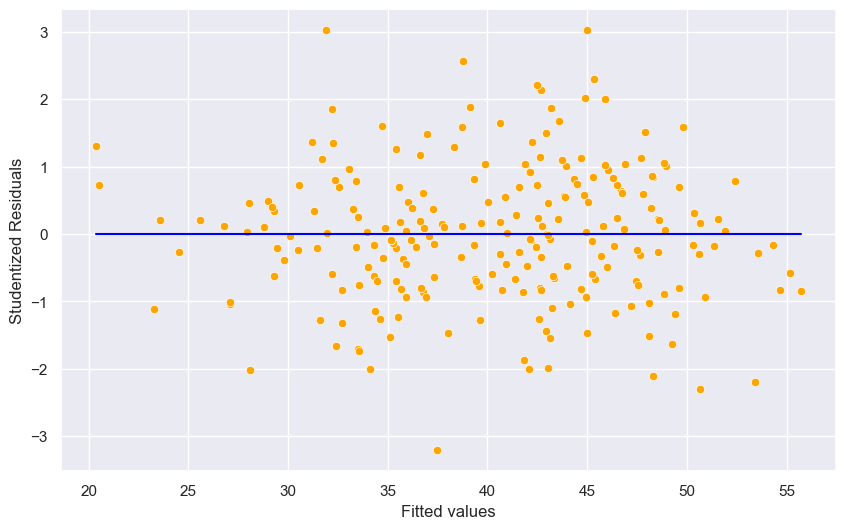

In [63]:
#Plotting studentized residuals vs fitted values
sns.scatterplot(x = (model.fittedvalues), y=(out.student_resid),color = 'orange')
sns.lineplot(x = [model.fittedvalues.min(),model.fittedvalues.max()],y = [0,0],color = 'blue')
plt.xlabel('Fitted values')
plt.ylabel('Studentized Residuals')
plt.show()

In [64]:
#Number of points with absolute studentized residuals greater than 3
np.sum((np.abs(out.student_resid)>3))

3

In [65]:
#only one outlier, and our predictors are all significant + our R squared is very high, so we don't need to worry about it.

#lets test leverage points
influence = model.get_influence()
leverage = influence.hat_matrix_diag

In [66]:
out = model.outlier_test()

#Average leverage of points
average_leverage = (model.df_model+1)/model.nobs
average_leverage

0.0125

In [67]:
#We will remove all observations that have leverage higher than the threshold value.
high_leverage_threshold = 4*average_leverage

#Number of high leverage points in the dataset
np.sum(leverage>high_leverage_threshold)

0

In [68]:
#no observations have 4 times more leverage than the avergae! Since there are no high leverage points, there are no 
# influential points

#testing for multicolinearity:
X = full_szns[['away_wins','goal_diff']]

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
X = add_constant(X)
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

for i in range(len(X.columns)):
    vif_data.loc[i,'VIF'] = variance_inflation_factor(X.values, i)

print(vif_data)

     feature        VIF
0      const  61.420052
1  away_wins   2.954141
2  goal_diff   2.954141


In [69]:
#no collinearity

In [70]:
# making a simple linear regression model to predict away win count
away_wins_model = smf.ols(formula = 'away_wins~goal_diff', data = full_szns).fit()
away_wins_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              away_wins   R-squared:                       0.661
Model:                            OLS   Adj. R-squared:                  0.660
Method:                 Least Squares   F-statistic:                     584.3
Date:                Wed, 15 Mar 2023   Prob (F-statistic):           2.65e-72
Time:                        01:07:03   Log-Likelihood:                -689.64
No. Observations:                 301   AIC:                             1383.
Df Residuals:                     299   BIC:                             1391.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     18.5947      0.138    134.408      0.000      18.322      18.867
goal_diff      0.0914      0.004     24.172      0.000       0.084       0.099
==============================================================================
Omnibus:                        1.273   Durbin-Watson:                   1.884
Prob(Omnibus):                  0.529   Jarque-Bera (JB):                1.294
Skew:                           0.156   Prob(JB):                        0.524
Kurtosis:                       2.924   Cond. No.                         36.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [71]:
# predators away game goal differential
preds_away['Goals For'].sum() - preds_away['Goals Against'].sum()

NameError: name 'preds_away' is not defined

In [ ]:
#predicting away game win count
away_wins_model.get_prediction({'goal_diff' : -5}).summary_frame(alpha=0.05)

In [ ]:
# simple linear regression model using goal differential and away_wins to predict total_wins
model = smf.ols(formula = 'total_wins~away_wins+goal_diff', data = full_szns).fit()
model.summary()

In [ ]:
# Preds current goal differential
preds_current_stats['Goals For'].sum() - preds_current_stats['Goals Against'].sum()

In [ ]:
# using this goal differential and the predicted away win count from the simple linear regression model
# to predict the Predators final win count 
model.get_prediction({'goal_diff' : -5, 'away_wins':18}).summary_frame(alpha=0.05)

Assuming the Predators continue to have a goal differential of -5 and follow a similar away win record for the second half of the season (leading on average to 18 games won), they are predicted with 95% confidense to have a final win count of either 39 or 40  games. Based on the EDA done previously in which we determined 43 games won to be a reliable benchmark for playoff caliber teams, the Predators are expected to be under that threshold with their current goal differential, based on the regression model.

In [ ]:
# breaking down the model so it can predict specific counts for home and away win counts

# making dataframes of home and away games for the Predators' current season
preds_home = preds_current_stats.loc[preds_current_stats['Unnamed: 3'] != '@']
preds_away = preds_current_stats.loc[preds_current_stats['Unnamed: 3'] == '@']

# making a simple linear regression model to predict home win count
home_wins_model = smf.ols(formula = 'home_wins~away_wins+goal_diff', data = full_szns).fit()
home_wins_model.summary()

In [ ]:
# predators home game goal differential
preds_home['Goals For'].sum() - preds_home['Goals Against'].sum()

In [ ]:
#predicting home win game count
home_wins_model.get_prediction({'goal_diff' : 0, 'away_wins':18}).summary_frame(alpha=0.05)

### Logistic Regression:
*By Elijah Nacar*

The Logistic Regression model is able to predict whether a team will make the playoffs or not based upon their end-of-season statistics. Used in conjunction with our Linear Regression Model that predicts a teams end-season-stats based upon current standings, we are able to predict whether the Predators will make the playoffs or not.

In [102]:
# Adding Binary Response (Binary Playoffs)
past_szns = pd.concat(szn_lists, axis=0, ignore_index=True) 
past_szns['binary_playoffs'] = past_szns['made_playoffs'].apply(lambda x: 1 if x == 'Yes' else 0)

# Testing the Accuracy of the Basic Model
model = smf.logit(formula = 'binary_playoffs~away_wins+home_wins+total_goals_against+total_goals_scored', data = past_szns).fit() #Developing logistic regression model
model.summary()

Optimization terminated successfully.
         Current function value: 0.147874
         Iterations 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:        binary_playoffs   No. Observations:                  330
Model:                          Logit   Df Residuals:                      325
Method:                           MLE   Df Model:                            4
Date:                Wed, 15 Mar 2023   Pseudo R-squ.:                  0.7865
Time:                        01:20:15   Log-Likelihood:                -48.798
converged:                       True   LL-Null:                       -228.59
Covariance Type:            nonrobust   LLR p-value:                 1.499e-76
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept             -18.4671      6.738     -2.741      0.006     -31.673      -5.261
away_wins               0.7085      0.177      3.996      0.000       0.361       1.056
home_wins               0.6762      0.159      4.250      0.000       0.364       0.988
total_goals_against    -0.0882      0.028     -3.129      0.002      -0.143      -0.033
total_goals_scored      0.0450      0.026      1.745      0.081      -0.006       0.096
=======================================================================================

Possibly complete quasi-separation: A fraction 0.28 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

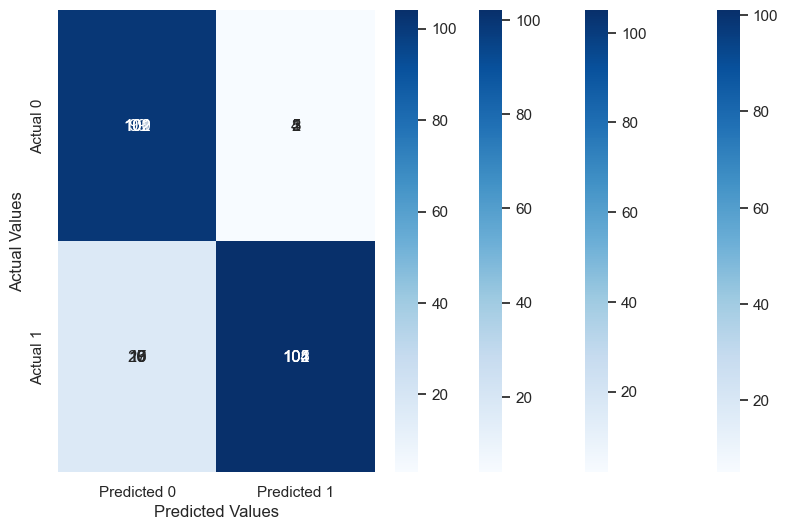

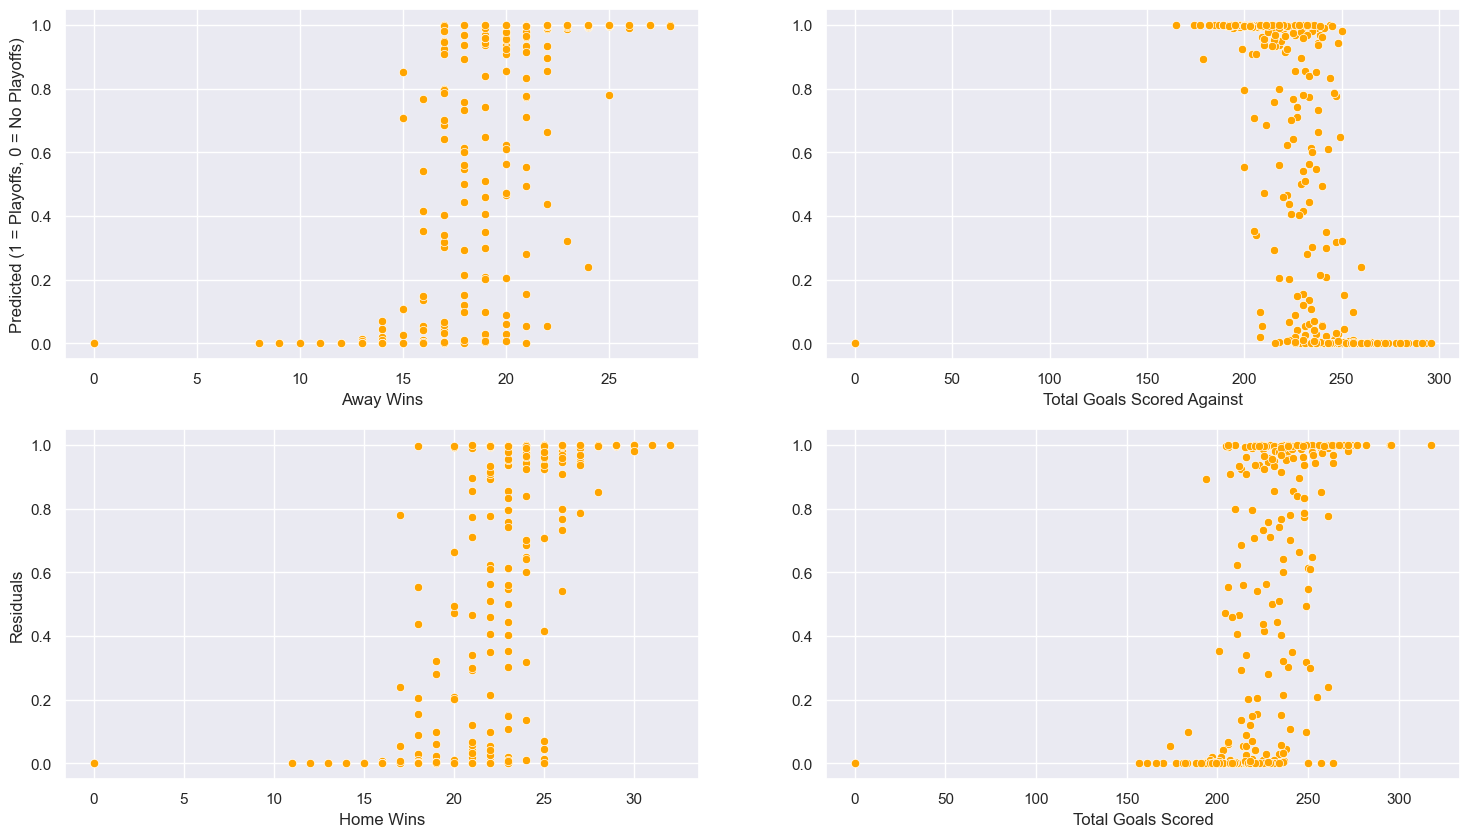

In [103]:
# Graph the Relationship between Predictor Variables and Model Prediction "Residuals" on Training Data
fig, axes = plt.subplots(2,2, figsize=(18, 10))

sns.scatterplot(ax=axes[0][0], x = past_szns.away_wins, y=model.predict(past_szns),color = 'orange')
axes[0][0].set_ylabel('Predicted (1 = Playoffs, 0 = No Playoffs)')
axes[0][0].set_xlabel('Away Wins')

sns.scatterplot(ax=axes[1][0], x = past_szns.home_wins, y=model.predict(past_szns),color = 'orange')
axes[1][0].set_xlabel('Home Wins')
axes[1][0].set_ylabel('Residuals')

sns.scatterplot(ax=axes[0][1], x = past_szns.total_goals_against, y=model.predict(past_szns),color = 'orange')
axes[0][1].set_xlabel('Total Goals Scored Against')

sns.scatterplot(ax=axes[1][1], x = past_szns.total_goals_scored, y=model.predict(past_szns),color = 'orange')
axes[1][1].set_xlabel('Total Goals Scored')
plt.show()

In [104]:
# Remove the Outliers to better the fit of the Model (pretty sure no team has not won a game or never scored a goal during the season)
past_szns = past_szns.loc[past_szns['home_wins'] != 0]
past_szns = past_szns.loc[past_szns['away_wins'] != 0]
past_szns = past_szns.loc[past_szns['total_goals_against'] != 0]
past_szns = past_szns.loc[past_szns['total_goals_scored'] != 0]

# Recalculate Model and Graphs without Outliers
model = smf.logit(formula = 'binary_playoffs~away_wins+home_wins+total_goals_against+total_goals_scored', data = past_szns).fit() #Developing logistic regression model
model.summary()

Optimization terminated successfully.
         Current function value: 0.162121
         Iterations 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:        binary_playoffs   No. Observations:                  301
Model:                          Logit   Df Residuals:                      296
Method:                           MLE   Df Model:                            4
Date:                Wed, 15 Mar 2023   Pseudo R-squ.:                  0.7654
Time:                        01:20:18   Log-Likelihood:                -48.798
converged:                       True   LL-Null:                       -208.04
Covariance Type:            nonrobust   LLR p-value:                 1.117e-67
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept             -18.4671      6.738     -2.741      0.006     -31.673      -5.261
away_wins               0.7085      0.177      3.996      0.000       0.361       1.056
home_wins               0.6762      0.159      4.250      0.000       0.364       0.988
total_goals_against    -0.0882      0.028     -3.129      0.002      -0.143      -0.033
total_goals_scored      0.0450      0.026      1.745      0.081      -0.006       0.096
=======================================================================================

Possibly complete quasi-separation: A fraction 0.22 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

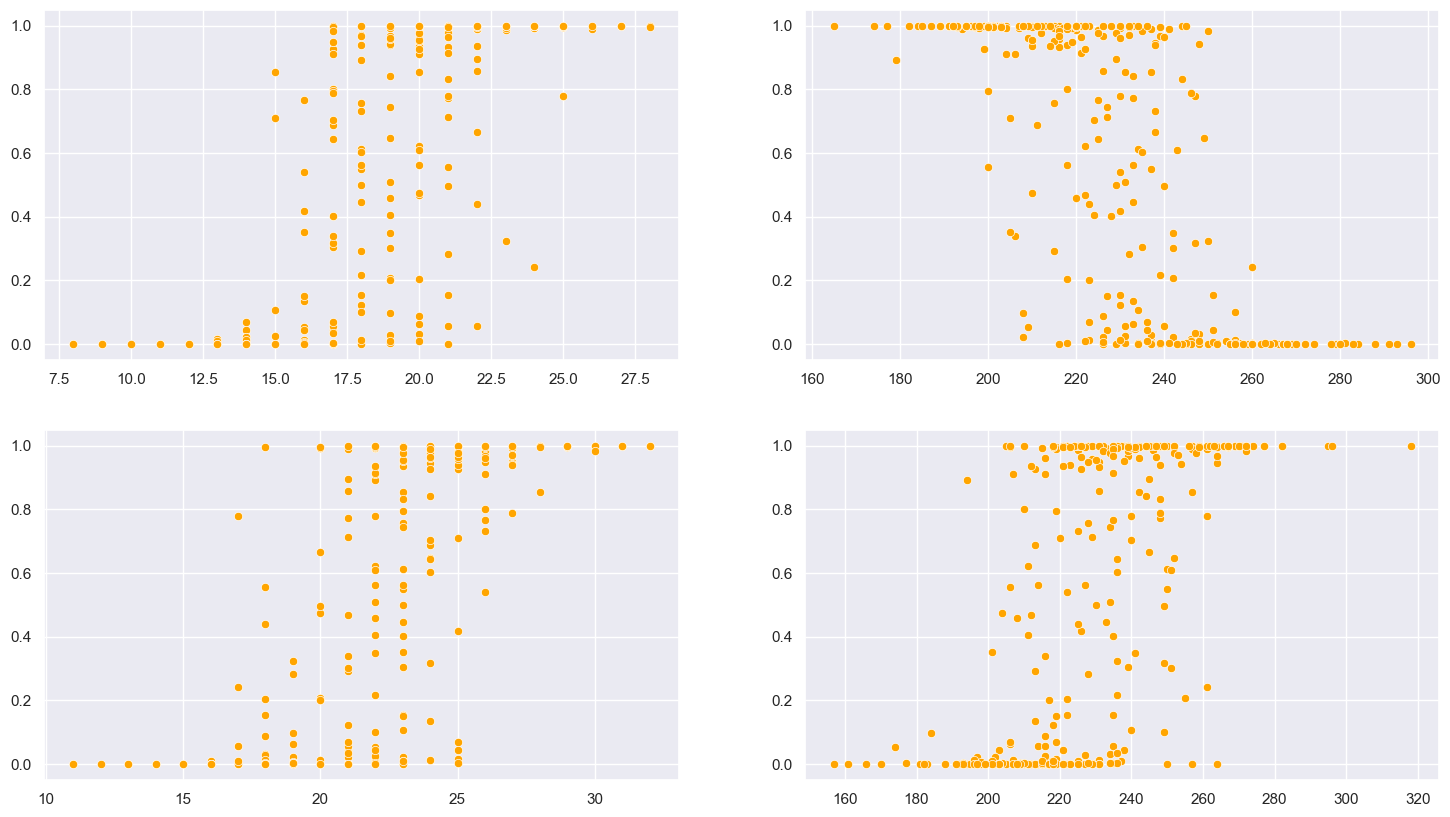

In [105]:
# Graph the Relationship between Predictor Variables and Model Prediction on Training Data (No Outliers)
fig, axes = plt.subplots(2,2, figsize=(18, 10))

sns.scatterplot(ax=axes[0][0], x = past_szns.away_wins, y=model.predict(past_szns),color = 'orange')
axes[0][0].set(xlabel=None)

sns.scatterplot(ax=axes[1][0], x = past_szns.home_wins, y=model.predict(past_szns),color = 'orange')
axes[1][0].set(xlabel=None)

sns.scatterplot(ax=axes[0][1], x = past_szns.total_goals_against, y=model.predict(past_szns),color = 'orange')
axes[0][1].set(xlabel=None)

sns.scatterplot(ax=axes[1][1], x = past_szns.total_goals_scored, y=model.predict(past_szns),color = 'orange')
axes[1][1].set(xlabel=None)
plt.show()

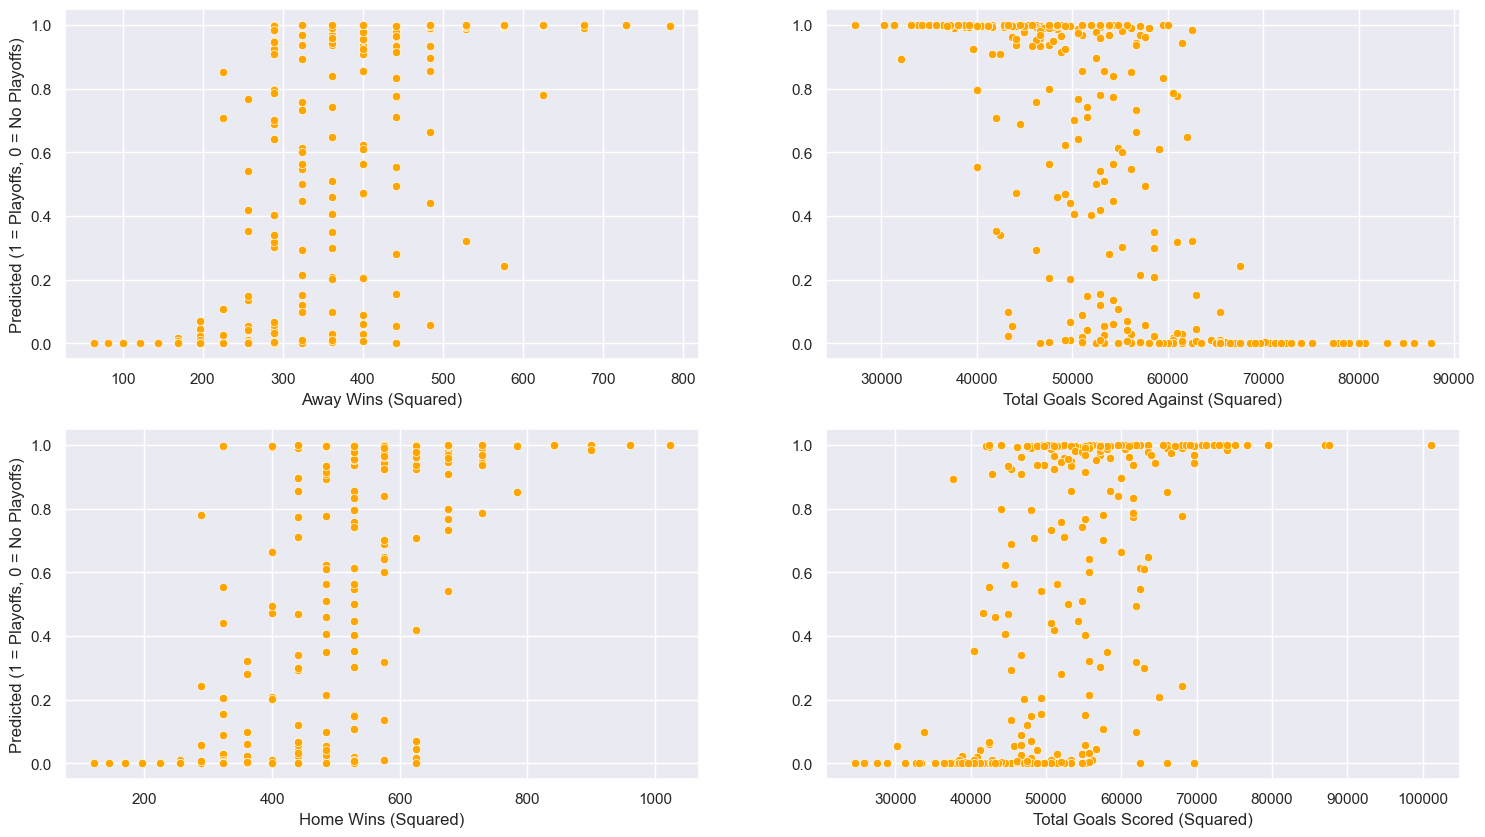

In [106]:
# Check Quadratic Transformations Since the Variables Seem to Have Curvature (no outliers)
past_szns['away_wins**2'] = past_szns['away_wins'].apply(lambda x: x*x)
past_szns['home_wins**2'] = past_szns['home_wins'].apply(lambda x: x*x)
past_szns['total_goals_against**2'] = past_szns['total_goals_against'].apply(lambda x: x*x)
past_szns['total_goals_scored**2'] = past_szns['total_goals_scored'].apply(lambda x: x*x)

fig, axes = plt.subplots(2,2, figsize=(18, 10))

sns.scatterplot(ax=axes[0][0], x = past_szns['away_wins**2'], y=model.predict(past_szns),color = 'orange')
axes[0][0].set_ylabel('Predicted (1 = Playoffs, 0 = No Playoffs)')
axes[0][0].set_xlabel('Away Wins (Squared)')

sns.scatterplot(ax=axes[1][0], x = past_szns['home_wins**2'], y=model.predict(past_szns),color = 'orange')
axes[1][0].set_xlabel('Home Wins (Squared)')
axes[1][0].set_ylabel('Predicted (1 = Playoffs, 0 = No Playoffs)')

sns.scatterplot(ax=axes[0][1], x = past_szns['total_goals_against**2'], y=model.predict(past_szns),color = 'orange')
axes[0][1].set_xlabel('Total Goals Scored Against (Squared)')

sns.scatterplot(ax=axes[1][1], x = past_szns['total_goals_scored**2'], y=model.predict(past_szns),color = 'orange')
axes[1][1].set_xlabel('Total Goals Scored (Squared)')
plt.show()

In [107]:
# Building Out Confusion Matrices
def confusion_matrix_train(model,cutoff=0.75):
    # Confusion matrix
    cm_df = pd.DataFrame(model.pred_table(threshold = cutoff))
    #Formatting the confusion matrix
    cm_df.columns = ['Predicted 0', 'Predicted 1'] 
    cm_df = cm_df.rename(index={0: 'Actual 0',1: 'Actual 1'})
    cm = np.array(cm_df)
    # Calculate the accuracy / Precision
    accuracy = (cm[0,0]+cm[1,1])/cm.sum()
    precision = (cm[1,1] / (cm[1,1]+cm[0,1]))
    sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
    plt.ylabel("Actual Values")
    plt.xlabel("Predicted Values")
    print("Classification accuracy = {:.1%}".format(accuracy))
    print("Precision = {:.1%}".format(precision))
    
def confusion_matrix_test(data,actual_values,model,cutoff=0.75):
#Predict the values using the Logit model
    pred_values = model.predict(data)
# Specify the bins
    bins=np.array([0,cutoff,1])
#Confusion matrix
    cm = np.histogram2d(actual_values, pred_values, bins=bins)[0]
    cm_df = pd.DataFrame(cm)
    cm_df.columns = ['Predicted 0','Predicted 1']
    cm_df = cm_df.rename(index={0: 'Actual 0',1:'Actual 1'})
    accuracy = (cm[0,0]+cm[1,1])/cm.sum()
    precision = (cm[1,1] / (cm[1,1]+cm[0,1]))
    sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
    plt.ylabel("Actual Values")
    plt.xlabel("Predicted Values")
    print("Classification accuracy = {:.1%}".format(accuracy))
    print("Precision = {:.1%}".format(precision))

In [108]:
# Building out Train / Test Dataset to Compare Accuracy/Precision
from sklearn.model_selection import train_test_split

train, test = train_test_split(past_szns)

# Standard Model with Relevant Predictors
model = smf.logit(formula = 'binary_playoffs~away_wins+home_wins+total_goals_against+total_goals_scored', data = train).fit()

# Cubic Transformation of Predictors
model2 = smf.logit(formula = 'binary_playoffs~away_wins+I(away_wins**2)+I(away_wins**3)+home_wins+I(home_wins**2)+I(home_wins**3)+total_goals_against+I(total_goals_against**2)+I(total_goals_against**3)+total_goals_scored+I(total_goals_scored**2)+I(total_goals_scored**3)', data = train).fit()

# Interactions between Wins / Goals
model3 = smf.logit(formula = 'binary_playoffs~away_wins*total_goals_against + home_wins*total_goals_against+away_wins*total_goals_scored+home_wins*total_goals_scored', data = train).fit()

# Interactions and Transformations
model4 = smf.logit(formula = 'binary_playoffs~(away_wins+I(away_wins**2)+I(away_wins**3))*total_goals_against + home_wins*total_goals_against+(away_wins+I(away_wins**2))*total_goals_scored + home_wins*total_goals_scored', data = train).fit() 

Optimization terminated successfully.
         Current function value: 0.179207
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.150444
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.175564
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.154238
         Iterations 31


In [109]:
confusion_matrix_train(model)
confusion_matrix_train(model2)
confusion_matrix_train(model3)
confusion_matrix_train(model4)

Classification accuracy = 90.2%
Precision = 96.9%
Classification accuracy = 91.6%
Precision = 96.1%
Classification accuracy = 90.2%
Precision = 96.9%
Classification accuracy = 91.6%
Precision = 98.0%


In [110]:
confusion_matrix_test(test, test.binary_playoffs, model)
confusion_matrix_test(test, test.binary_playoffs, model2)
confusion_matrix_test(test, test.binary_playoffs, model3)
confusion_matrix_test(test, test.binary_playoffs, model4)

Classification accuracy = 92.1%
Precision = 100.0%
Classification accuracy = 90.8%
Precision = 95.3%
Classification accuracy = 92.1%
Precision = 100.0%
Classification accuracy = 90.8%
Precision = 100.0%


While numbers vary due to the way we split testing/training data, Model3 performs the best on test data / Precision

# Code fitting the final model

Put the code(s) that fit the final model(s) in separate cell(s), i.e., the code with the `.ols()` or `.logit()` functions.

### Linear Model:

*Samuel Sword*

In [111]:
model = smf.ols(formula = 'away_wins~goal_diff', data = full_szns).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              away_wins   R-squared:                       0.661
Model:                            OLS   Adj. R-squared:                  0.660
Method:                 Least Squares   F-statistic:                     584.3
Date:                Wed, 15 Mar 2023   Prob (F-statistic):           2.65e-72
Time:                        01:20:24   Log-Likelihood:                -689.64
No. Observations:                 301   AIC:                             1383.
Df Residuals:                     299   BIC:                             1391.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     18.5947      0.138    134.408      0.000      18.322      18.867
goal_diff      0.0914      0.004     24.172      0.000       0.084       0.099
==============================================================================
Omnibus:                        1.273   Durbin-Watson:                   1.884
Prob(Omnibus):                  0.529   Jarque-Bera (JB):                1.294
Skew:                           0.156   Prob(JB):                        0.524
Kurtosis:                       2.924   Cond. No.                         36.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [112]:
home_wins_model = smf.ols(formula = 'home_wins~away_wins+goal_diff', data = full_szns).fit()
home_wins_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              home_wins   R-squared:                       0.773
Model:                            OLS   Adj. R-squared:                  0.772
Method:                 Least Squares   F-statistic:                     508.2
Date:                Wed, 15 Mar 2023   Prob (F-statistic):           9.23e-97
Time:                        01:20:24   Log-Likelihood:                -636.18
No. Observations:                 301   AIC:                             1278.
Df Residuals:                     298   BIC:                             1289.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     33.0601      0.909     36.357      0.000      31.271      34.850
away_wins     -0.5730      0.049    -11.814      0.000      -0.668      -0.478
goal_diff      0.1463      0.005     26.837      0.000       0.136       0.157
==============================================================================
Omnibus:                        0.505   Durbin-Watson:                   2.084
Prob(Omnibus):                  0.777   Jarque-Bera (JB):                0.316
Skew:                           0.060   Prob(JB):                        0.854
Kurtosis:                       3.104   Cond. No.                         289.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [113]:
away_wins_model = smf.ols(formula = 'total_wins~away_wins+goal_diff', data = full_szns).fit()
away_wins_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             total_wins   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                     1746.
Date:                Wed, 15 Mar 2023   Prob (F-statistic):          2.76e-165
Time:                        01:20:24   Log-Likelihood:                -636.18
No. Observations:                 301   AIC:                             1278.
Df Residuals:                     298   BIC:                             1289.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     33.0601      0.909     36.357      0.000      31.271      34.850
away_wins      0.4270      0.049      8.804      0.000       0.332       0.522
goal_diff      0.1463      0.005     26.837      0.000       0.136       0.157
==============================================================================
Omnibus:                        0.505   Durbin-Watson:                   2.084
Prob(Omnibus):                  0.777   Jarque-Bera (JB):                0.316
Skew:                           0.060   Prob(JB):                        0.854
Kurtosis:                       3.104   Cond. No.                         289.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Logistic Model:

In [116]:
# Interactions between Wins / Goals
model3 = smf.logit(formula = 'binary_playoffs~away_wins*total_goals_against + home_wins*total_goals_against+away_wins*total_goals_scored+home_wins*total_goals_scored', data = train).fit()
model3.summary()

Optimization terminated successfully.
         Current function value: 0.175564
         Iterations 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:        binary_playoffs   No. Observations:                  225
Model:                          Logit   Df Residuals:                      216
Method:                           MLE   Df Model:                            8
Date:                Wed, 15 Mar 2023   Pseudo R-squ.:                  0.7467
Time:                        01:22:34   Log-Likelihood:                -39.502
converged:                       True   LL-Null:                       -155.94
Covariance Type:            nonrobust   LLR p-value:                 7.308e-46
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                       -20.4951     85.638     -0.239      0.811    -188.342     147.352
away_wins                         1.7239      2.514      0.686      0.493      -3.204       6.652
total_goals_against               0.0833      0.379      0.219      0.826      -0.660       0.827
away_wins:total_goals_against    -0.0108      0.011     -0.999      0.318      -0.032       0.010
home_wins                        -0.1932      2.202     -0.088      0.930      -4.509       4.122
home_wins:total_goals_against     0.0009      0.011      0.078      0.938      -0.022       0.023
total_goals_scored               -0.0921      0.343     -0.269      0.788      -0.764       0.580
away_wins:total_goals_scored      0.0058      0.010      0.554      0.580      -0.015       0.026
home_wins:total_goals_scored      0.0022      0.010      0.221      0.825      -0.017       0.022
=================================================================================================

Possibly complete quasi-separation: A fraction 0.14 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

## Conclusions and Recommendations to stakeholder(s)

*By Elijah Nacar*

While we still have room to create a larger collection of possible recommendations, we chose to find and recommend the simplest path to playoffs, in our mind, for the Nashville Predators. Our recommendations are elementary, and we would build upon them in the future as an extension to the project.

In [118]:
# Creating a Dataframe of all the possible end-season-statistics for the Nashville Predators
# We will later utilize the Linear Regression Model's prediction to wins to determine whether
# the Predators are predicted to make the Playoffs currently.
rows = []

for home_win in range(9, 33):
    for away_win in range(10, 30):
        for goals_scored in range(112, 237):
            for goals_against in range(117, 242):
                rows.append([home_win, away_win, goals_scored, goals_against])

preds_df = pd.DataFrame(rows, columns = ['home_wins','away_wins','total_goals_scored','total_goals_against'])

# Predict Whether the Predators will make the playoffs at each of these end season stats
preds_df['predicted_playoff'] = model3.predict(preds_df)
preds_df

,home_wins,away_wins,total_goals_scored,total_goals_against,predicted_playoff
0,9,10,112,117,0.000196
1,9,10,112,118,0.000193
2,9,10,112,119,0.000190
3,9,10,112,120,0.000187
4,9,10,112,121,0.000184
...,...,...,...,...,...
7499995,32,29,236,237,0.999965
7499996,32,29,236,238,0.999957
7499997,32,29,236,239,0.999948
7499998,32,29,236,240,0.999936


In [119]:
# Set a High Threshold (75%) because we care more about the accuracy of our recommendation
# Determine whether our model predicts a team to qualify with a 75% threshold
preds_df['binary_playoff'] = preds_df['predicted_playoff'].apply(lambda x: 1 if x >= 0.75 else 0)
preds_df.loc[preds_df['binary_playoff']==1].shape[0] / preds_df.shape[0]

0.43135413333333333

Based on this result, the Predators make the playoffs in ~43% of their possible end season stats. To simplify our prediction, lets look at how many home/away wins the Predators would need to qualify with their current scoring averages. Based on our model, how many wins do the Predators need if they continue to score/get scored against at the same rate?

In [120]:
# Recommendations based on current goals scored, against trajectory
avg_goals_pd = preds_df.loc[(preds_df['total_goals_scored'] == 199) & (preds_df['total_goals_against'] == 207)]

# Look at the collective "probability" that the team will qualify based upon different number of home_wins
avg_goals_pd.groupby('home_wins')['predicted_playoff'].mean()

home_wins
9     0.120324
10    0.147715
11    0.176907
12    0.207402
13    0.238808
14    0.270836
15    0.303282
16    0.336004
17    0.368906
18    0.401926
19    0.435018
20    0.468151
21    0.501304
22    0.534456
23    0.567588
24    0.600675
25    0.633687
26    0.666578
27    0.699282
28    0.731701
29    0.763688
30    0.795034
31    0.825443
32    0.854513
Name: predicted_playoff, dtype: float64

In [121]:
# Look at the collective "probability that the team will qualify based upon different number of away wins
avg_goals_pd.groupby('away_wins')['predicted_playoff'].mean()

away_wins
10    0.025906
11    0.044645
12    0.072710
13    0.110721
14    0.157441
15    0.210563
16    0.267803
17    0.327459
18    0.388440
19    0.450087
20    0.511988
21    0.573830
22    0.635278
23    0.695843
24    0.754723
25    0.810607
26    0.861543
27    0.905133
28    0.939344
29    0.963624
Name: predicted_playoff, dtype: float64

In [125]:
# For the sake of simplicity (in the future our model would include a myriad of recommendations), we recommend a simple 
# combination of 20 home wins/22 away wins with their current scoring trajectory as this combination, our model predicts,
# will allow the team to qualify.
model3.predict(pd.DataFrame([[20, 22, 199, 207]], columns=['home_wins','away_wins','total_goals_scored', 'total_goals_against']))

0    0.768808
dtype: float64